In [12]:
import dlc_practical_prologue as prologue

In [13]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [14]:
# Sometimes directly download will cause http403 error
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [15]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [16]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


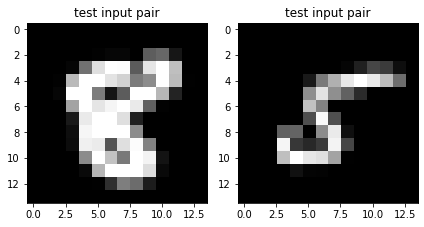

The test classes are: 8 and 5.
The test target is: 0


In [17]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [32]:
#Simple CNN
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_drop=nn.Dropout2d()
        
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return x

        # Training Function

    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set, and plot the loss and accuracy function
        Print the used time.
        :param train_input: Training input data
        :param train_target: Training labels
        :param test_input: Testing input data
        :param test_target: Testing labels
        """
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
#                 # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [33]:
# build the net instance
my_model=CNN_Net()
# save the model
my_model.save_model('CNN_Net.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 0.729384
Epoch: 001/025 | Batch 050/1000 | Loss: 0.819978
Epoch: 001/025 | Batch 100/1000 | Loss: 0.744958
Epoch: 001/025 | Batch 150/1000 | Loss: 0.699671
Epoch: 001/025 | Batch 200/1000 | Loss: 0.780112
Epoch: 001/025 | Batch 250/1000 | Loss: 0.890692
Epoch: 001/025 | Batch 300/1000 | Loss: 0.634096
Epoch: 001/025 | Batch 350/1000 | Loss: 0.653294
Epoch: 001/025 | Batch 400/1000 | Loss: 0.636038
Epoch: 001/025 | Batch 450/1000 | Loss: 0.648608
Epoch: 001/025 | Batch 500/1000 | Loss: 0.689758
Epoch: 001/025 | Batch 550/1000 | Loss: 0.678148
Epoch: 001/025 | Batch 600/1000 | Loss: 0.717753
Epoch: 001/025 | Batch 650/1000 | Loss: 0.675808
Epoch: 001/025 | Batch 700/1000 | Loss: 0.628812
Epoch: 001/025 | Batch 750/1000 | Loss: 0.632603
Epoch: 001/025 | Batch 800/1000 | Loss: 0.574039
Epoch: 001/025 | Batch 850/1000 | Loss: 0.665985
Epoch: 001/025 | Batch 900/1000 | Loss: 0.610171
Epoch: 001/025 | Batch 950/1000 | Loss: 0.607084
Time elapsed: 0.00 m

Epoch: 010/025 | Batch 000/1000 | Loss: 0.044523
Epoch: 010/025 | Batch 050/1000 | Loss: 0.029925
Epoch: 010/025 | Batch 100/1000 | Loss: 0.031233
Epoch: 010/025 | Batch 150/1000 | Loss: 0.026658
Epoch: 010/025 | Batch 200/1000 | Loss: 0.033286
Epoch: 010/025 | Batch 250/1000 | Loss: 0.041733
Epoch: 010/025 | Batch 300/1000 | Loss: 0.051752
Epoch: 010/025 | Batch 350/1000 | Loss: 0.043528
Epoch: 010/025 | Batch 400/1000 | Loss: 0.022649
Epoch: 010/025 | Batch 450/1000 | Loss: 0.040292
Epoch: 010/025 | Batch 500/1000 | Loss: 0.025088
Epoch: 010/025 | Batch 550/1000 | Loss: 0.025357
Epoch: 010/025 | Batch 600/1000 | Loss: 0.018161
Epoch: 010/025 | Batch 650/1000 | Loss: 0.036551
Epoch: 010/025 | Batch 700/1000 | Loss: 0.016112
Epoch: 010/025 | Batch 750/1000 | Loss: 0.025263
Epoch: 010/025 | Batch 800/1000 | Loss: 0.020870
Epoch: 010/025 | Batch 850/1000 | Loss: 0.027776
Epoch: 010/025 | Batch 900/1000 | Loss: 0.038283
Epoch: 010/025 | Batch 950/1000 | Loss: 0.018820
Time elapsed: 0.06 m

Epoch: 018/025 | Batch 950/1000 | Loss: 0.006950
Time elapsed: 0.11 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.013091
Epoch: 019/025 | Batch 050/1000 | Loss: 0.021689
Epoch: 019/025 | Batch 100/1000 | Loss: 0.000770
Epoch: 019/025 | Batch 150/1000 | Loss: 0.002336
Epoch: 019/025 | Batch 200/1000 | Loss: 0.002352
Epoch: 019/025 | Batch 250/1000 | Loss: 0.002208
Epoch: 019/025 | Batch 300/1000 | Loss: 0.008074
Epoch: 019/025 | Batch 350/1000 | Loss: 0.004436
Epoch: 019/025 | Batch 400/1000 | Loss: 0.004747
Epoch: 019/025 | Batch 450/1000 | Loss: 0.003296
Epoch: 019/025 | Batch 500/1000 | Loss: 0.001454
Epoch: 019/025 | Batch 550/1000 | Loss: 0.005118
Epoch: 019/025 | Batch 600/1000 | Loss: 0.004425
Epoch: 019/025 | Batch 650/1000 | Loss: 0.017814
Epoch: 019/025 | Batch 700/1000 | Loss: 0.003665
Epoch: 019/025 | Batch 750/1000 | Loss: 0.008902
Epoch: 019/025 | Batch 800/1000 | Loss: 0.003770
Epoch: 019/025 | Batch 850/1000 | Loss: 0.008888
Epoch: 019/025 | Batch 900/1000 | Loss: 0.0132

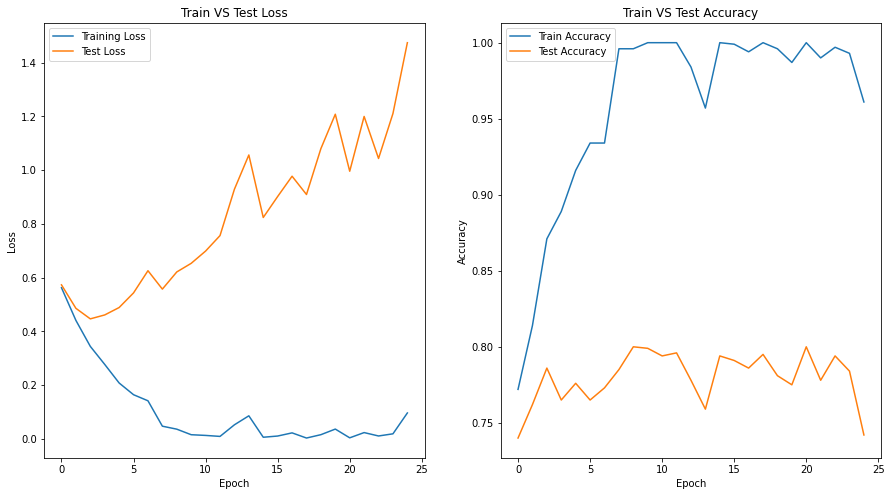

In [34]:
# train the model
my_model.trainer(train_input, train_target, test_input, test_target)

In [35]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 76386


Epoch: 001/025 | Batch 000/1000 | Loss: 0.798437
Epoch: 001/025 | Batch 050/1000 | Loss: 0.874692
Epoch: 001/025 | Batch 100/1000 | Loss: 0.753825
Epoch: 001/025 | Batch 150/1000 | Loss: 0.729246
Epoch: 001/025 | Batch 200/1000 | Loss: 0.704552
Epoch: 001/025 | Batch 250/1000 | Loss: 0.647956
Epoch: 001/025 | Batch 300/1000 | Loss: 0.744713
Epoch: 001/025 | Batch 350/1000 | Loss: 0.629503
Epoch: 001/025 | Batch 400/1000 | Loss: 0.598494
Epoch: 001/025 | Batch 450/1000 | Loss: 0.617580
Epoch: 001/025 | Batch 500/1000 | Loss: 0.701478
Epoch: 001/025 | Batch 550/1000 | Loss: 0.675295
Epoch: 001/025 | Batch 600/1000 | Loss: 0.624928
Epoch: 001/025 | Batch 650/1000 | Loss: 0.577733
Epoch: 001/025 | Batch 700/1000 | Loss: 0.670675
Epoch: 001/025 | Batch 750/1000 | Loss: 0.622221
Epoch: 001/025 | Batch 800/1000 | Loss: 0.605826
Epoch: 001/025 | Batch 850/1000 | Loss: 0.713229
Epoch: 001/025 | Batch 900/1000 | Loss: 0.628081
Epoch: 001/025 | Batch 950/1000 | Loss: 0.650008
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 800/1000 | Loss: 0.112448
Epoch: 009/025 | Batch 850/1000 | Loss: 0.046107
Epoch: 009/025 | Batch 900/1000 | Loss: 0.077606
Epoch: 009/025 | Batch 950/1000 | Loss: 0.107652
Time elapsed: 0.06 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.066517
Epoch: 010/025 | Batch 050/1000 | Loss: 0.137465
Epoch: 010/025 | Batch 100/1000 | Loss: 0.094981
Epoch: 010/025 | Batch 150/1000 | Loss: 0.068523
Epoch: 010/025 | Batch 200/1000 | Loss: 0.056500
Epoch: 010/025 | Batch 250/1000 | Loss: 0.095720
Epoch: 010/025 | Batch 300/1000 | Loss: 0.056325
Epoch: 010/025 | Batch 350/1000 | Loss: 0.038164
Epoch: 010/025 | Batch 400/1000 | Loss: 0.071740
Epoch: 010/025 | Batch 450/1000 | Loss: 0.066059
Epoch: 010/025 | Batch 500/1000 | Loss: 0.036545
Epoch: 010/025 | Batch 550/1000 | Loss: 0.033507
Epoch: 010/025 | Batch 600/1000 | Loss: 0.056441
Epoch: 010/025 | Batch 650/1000 | Loss: 0.041747
Epoch: 010/025 | Batch 700/1000 | Loss: 0.034112
Epoch: 010/025 | Batch 750/1000 | Loss: 0.0643

Epoch: 018/025 | Batch 000/1000 | Loss: 0.011158
Epoch: 018/025 | Batch 050/1000 | Loss: 0.030734
Epoch: 018/025 | Batch 100/1000 | Loss: 0.004758
Epoch: 018/025 | Batch 150/1000 | Loss: 0.009320
Epoch: 018/025 | Batch 200/1000 | Loss: 0.036675
Epoch: 018/025 | Batch 250/1000 | Loss: 0.029852
Epoch: 018/025 | Batch 300/1000 | Loss: 0.006549
Epoch: 018/025 | Batch 350/1000 | Loss: 0.010097
Epoch: 018/025 | Batch 400/1000 | Loss: 0.008583
Epoch: 018/025 | Batch 450/1000 | Loss: 0.025620
Epoch: 018/025 | Batch 500/1000 | Loss: 0.022752
Epoch: 018/025 | Batch 550/1000 | Loss: 0.029987
Epoch: 018/025 | Batch 600/1000 | Loss: 0.032672
Epoch: 018/025 | Batch 650/1000 | Loss: 0.068861
Epoch: 018/025 | Batch 700/1000 | Loss: 0.018439
Epoch: 018/025 | Batch 750/1000 | Loss: 0.015704
Epoch: 018/025 | Batch 800/1000 | Loss: 0.010617
Epoch: 018/025 | Batch 850/1000 | Loss: 0.017655
Epoch: 018/025 | Batch 900/1000 | Loss: 0.036170
Epoch: 018/025 | Batch 950/1000 | Loss: 0.054089
Time elapsed: 0.13 m

Epoch: 001/025 | Batch 850/1000 | Loss: 0.561330
Epoch: 001/025 | Batch 900/1000 | Loss: 0.548260
Epoch: 001/025 | Batch 950/1000 | Loss: 0.572100
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.540741
Epoch: 002/025 | Batch 050/1000 | Loss: 0.502757
Epoch: 002/025 | Batch 100/1000 | Loss: 0.555635
Epoch: 002/025 | Batch 150/1000 | Loss: 0.520272
Epoch: 002/025 | Batch 200/1000 | Loss: 0.569232
Epoch: 002/025 | Batch 250/1000 | Loss: 0.424737
Epoch: 002/025 | Batch 300/1000 | Loss: 0.524779
Epoch: 002/025 | Batch 350/1000 | Loss: 0.545171
Epoch: 002/025 | Batch 400/1000 | Loss: 0.552865
Epoch: 002/025 | Batch 450/1000 | Loss: 0.466417
Epoch: 002/025 | Batch 500/1000 | Loss: 0.493408
Epoch: 002/025 | Batch 550/1000 | Loss: 0.506912
Epoch: 002/025 | Batch 600/1000 | Loss: 0.456394
Epoch: 002/025 | Batch 650/1000 | Loss: 0.399301
Epoch: 002/025 | Batch 700/1000 | Loss: 0.519491
Epoch: 002/025 | Batch 750/1000 | Loss: 0.526977
Epoch: 002/025 | Batch 800/1000 | Loss: 0.4375

Epoch: 010/025 | Batch 050/1000 | Loss: 0.047386
Epoch: 010/025 | Batch 100/1000 | Loss: 0.051865
Epoch: 010/025 | Batch 150/1000 | Loss: 0.034438
Epoch: 010/025 | Batch 200/1000 | Loss: 0.050002
Epoch: 010/025 | Batch 250/1000 | Loss: 0.022791
Epoch: 010/025 | Batch 300/1000 | Loss: 0.099786
Epoch: 010/025 | Batch 350/1000 | Loss: 0.086987
Epoch: 010/025 | Batch 400/1000 | Loss: 0.027730
Epoch: 010/025 | Batch 450/1000 | Loss: 0.059811
Epoch: 010/025 | Batch 500/1000 | Loss: 0.035692
Epoch: 010/025 | Batch 550/1000 | Loss: 0.087656
Epoch: 010/025 | Batch 600/1000 | Loss: 0.031412
Epoch: 010/025 | Batch 650/1000 | Loss: 0.046861
Epoch: 010/025 | Batch 700/1000 | Loss: 0.022051
Epoch: 010/025 | Batch 750/1000 | Loss: 0.121665
Epoch: 010/025 | Batch 800/1000 | Loss: 0.049551
Epoch: 010/025 | Batch 850/1000 | Loss: 0.060699
Epoch: 010/025 | Batch 900/1000 | Loss: 0.036013
Epoch: 010/025 | Batch 950/1000 | Loss: 0.019657
Time elapsed: 0.07 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.0379

Epoch: 018/025 | Batch 750/1000 | Loss: 0.012484
Epoch: 018/025 | Batch 800/1000 | Loss: 0.012259
Epoch: 018/025 | Batch 850/1000 | Loss: 0.002150
Epoch: 018/025 | Batch 900/1000 | Loss: 0.008212
Epoch: 018/025 | Batch 950/1000 | Loss: 0.002598
Time elapsed: 0.13 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.002632
Epoch: 019/025 | Batch 050/1000 | Loss: 0.002097
Epoch: 019/025 | Batch 100/1000 | Loss: 0.006782
Epoch: 019/025 | Batch 150/1000 | Loss: 0.002620
Epoch: 019/025 | Batch 200/1000 | Loss: 0.002375
Epoch: 019/025 | Batch 250/1000 | Loss: 0.005852
Epoch: 019/025 | Batch 300/1000 | Loss: 0.003338
Epoch: 019/025 | Batch 350/1000 | Loss: 0.003879
Epoch: 019/025 | Batch 400/1000 | Loss: 0.004185
Epoch: 019/025 | Batch 450/1000 | Loss: 0.011050
Epoch: 019/025 | Batch 500/1000 | Loss: 0.002404
Epoch: 019/025 | Batch 550/1000 | Loss: 0.001325
Epoch: 019/025 | Batch 600/1000 | Loss: 0.000504
Epoch: 019/025 | Batch 650/1000 | Loss: 0.002330
Epoch: 019/025 | Batch 700/1000 | Loss: 0.0027

Epoch: 002/025 | Batch 100/1000 | Loss: 0.538478
Epoch: 002/025 | Batch 150/1000 | Loss: 0.585068
Epoch: 002/025 | Batch 200/1000 | Loss: 0.562666
Epoch: 002/025 | Batch 250/1000 | Loss: 0.518964
Epoch: 002/025 | Batch 300/1000 | Loss: 0.566315
Epoch: 002/025 | Batch 350/1000 | Loss: 0.528663
Epoch: 002/025 | Batch 400/1000 | Loss: 0.473127
Epoch: 002/025 | Batch 450/1000 | Loss: 0.584539
Epoch: 002/025 | Batch 500/1000 | Loss: 0.537965
Epoch: 002/025 | Batch 550/1000 | Loss: 0.496387
Epoch: 002/025 | Batch 600/1000 | Loss: 0.486588
Epoch: 002/025 | Batch 650/1000 | Loss: 0.486870
Epoch: 002/025 | Batch 700/1000 | Loss: 0.419631
Epoch: 002/025 | Batch 750/1000 | Loss: 0.520415
Epoch: 002/025 | Batch 800/1000 | Loss: 0.604492
Epoch: 002/025 | Batch 850/1000 | Loss: 0.460303
Epoch: 002/025 | Batch 900/1000 | Loss: 0.516397
Epoch: 002/025 | Batch 950/1000 | Loss: 0.490470
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.418643
Epoch: 003/025 | Batch 050/1000 | Loss: 0.4924

Epoch: 010/025 | Batch 500/1000 | Loss: 0.273236
Epoch: 010/025 | Batch 550/1000 | Loss: 0.070067
Epoch: 010/025 | Batch 600/1000 | Loss: 0.109670
Epoch: 010/025 | Batch 650/1000 | Loss: 0.119692
Epoch: 010/025 | Batch 700/1000 | Loss: 0.441004
Epoch: 010/025 | Batch 750/1000 | Loss: 0.388188
Epoch: 010/025 | Batch 800/1000 | Loss: 0.164501
Epoch: 010/025 | Batch 850/1000 | Loss: 0.052342
Epoch: 010/025 | Batch 900/1000 | Loss: 0.148358
Epoch: 010/025 | Batch 950/1000 | Loss: 0.287316
Time elapsed: 0.07 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.443433
Epoch: 011/025 | Batch 050/1000 | Loss: 0.149972
Epoch: 011/025 | Batch 100/1000 | Loss: 0.078086
Epoch: 011/025 | Batch 150/1000 | Loss: 0.050784
Epoch: 011/025 | Batch 200/1000 | Loss: 0.081175
Epoch: 011/025 | Batch 250/1000 | Loss: 0.108562
Epoch: 011/025 | Batch 300/1000 | Loss: 0.320535
Epoch: 011/025 | Batch 350/1000 | Loss: 0.185317
Epoch: 011/025 | Batch 400/1000 | Loss: 0.124624
Epoch: 011/025 | Batch 450/1000 | Loss: 0.0770

Epoch: 018/025 | Batch 950/1000 | Loss: 0.080703
Time elapsed: 0.13 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.030447
Epoch: 019/025 | Batch 050/1000 | Loss: 0.028550
Epoch: 019/025 | Batch 100/1000 | Loss: 0.017086
Epoch: 019/025 | Batch 150/1000 | Loss: 0.039558
Epoch: 019/025 | Batch 200/1000 | Loss: 0.013752
Epoch: 019/025 | Batch 250/1000 | Loss: 0.155874
Epoch: 019/025 | Batch 300/1000 | Loss: 0.036152
Epoch: 019/025 | Batch 350/1000 | Loss: 0.025245
Epoch: 019/025 | Batch 400/1000 | Loss: 0.021778
Epoch: 019/025 | Batch 450/1000 | Loss: 0.026153
Epoch: 019/025 | Batch 500/1000 | Loss: 0.024198
Epoch: 019/025 | Batch 550/1000 | Loss: 0.006619
Epoch: 019/025 | Batch 600/1000 | Loss: 0.026285
Epoch: 019/025 | Batch 650/1000 | Loss: 0.026198
Epoch: 019/025 | Batch 700/1000 | Loss: 0.003691
Epoch: 019/025 | Batch 750/1000 | Loss: 0.021135
Epoch: 019/025 | Batch 800/1000 | Loss: 0.030690
Epoch: 019/025 | Batch 850/1000 | Loss: 0.059615
Epoch: 019/025 | Batch 900/1000 | Loss: 0.0754

Epoch: 002/025 | Batch 850/1000 | Loss: 0.464079
Epoch: 002/025 | Batch 900/1000 | Loss: 0.453823
Epoch: 002/025 | Batch 950/1000 | Loss: 0.467780
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.290891
Epoch: 003/025 | Batch 050/1000 | Loss: 0.481057
Epoch: 003/025 | Batch 100/1000 | Loss: 0.430940
Epoch: 003/025 | Batch 150/1000 | Loss: 0.324811
Epoch: 003/025 | Batch 200/1000 | Loss: 0.408945
Epoch: 003/025 | Batch 250/1000 | Loss: 0.355573
Epoch: 003/025 | Batch 300/1000 | Loss: 0.323881
Epoch: 003/025 | Batch 350/1000 | Loss: 0.489641
Epoch: 003/025 | Batch 400/1000 | Loss: 0.306523
Epoch: 003/025 | Batch 450/1000 | Loss: 0.454279
Epoch: 003/025 | Batch 500/1000 | Loss: 0.447026
Epoch: 003/025 | Batch 550/1000 | Loss: 0.451602
Epoch: 003/025 | Batch 600/1000 | Loss: 0.476754
Epoch: 003/025 | Batch 650/1000 | Loss: 0.343509
Epoch: 003/025 | Batch 700/1000 | Loss: 0.408554
Epoch: 003/025 | Batch 750/1000 | Loss: 0.359014
Epoch: 003/025 | Batch 800/1000 | Loss: 0.3470

Epoch: 011/025 | Batch 000/1000 | Loss: 0.028909
Epoch: 011/025 | Batch 050/1000 | Loss: 0.048123
Epoch: 011/025 | Batch 100/1000 | Loss: 0.060145
Epoch: 011/025 | Batch 150/1000 | Loss: 0.033540
Epoch: 011/025 | Batch 200/1000 | Loss: 0.014518
Epoch: 011/025 | Batch 250/1000 | Loss: 0.008439
Epoch: 011/025 | Batch 300/1000 | Loss: 0.012278
Epoch: 011/025 | Batch 350/1000 | Loss: 0.027496
Epoch: 011/025 | Batch 400/1000 | Loss: 0.020218
Epoch: 011/025 | Batch 450/1000 | Loss: 0.046878
Epoch: 011/025 | Batch 500/1000 | Loss: 0.045097
Epoch: 011/025 | Batch 550/1000 | Loss: 0.021803
Epoch: 011/025 | Batch 600/1000 | Loss: 0.018483
Epoch: 011/025 | Batch 650/1000 | Loss: 0.014510
Epoch: 011/025 | Batch 700/1000 | Loss: 0.014694
Epoch: 011/025 | Batch 750/1000 | Loss: 0.020002
Epoch: 011/025 | Batch 800/1000 | Loss: 0.018319
Epoch: 011/025 | Batch 850/1000 | Loss: 0.020108
Epoch: 011/025 | Batch 900/1000 | Loss: 0.012221
Epoch: 011/025 | Batch 950/1000 | Loss: 0.006819
Time elapsed: 0.08 m

Epoch: 019/025 | Batch 900/1000 | Loss: 0.001614
Epoch: 019/025 | Batch 950/1000 | Loss: 0.002097
Time elapsed: 0.16 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.001491
Epoch: 020/025 | Batch 050/1000 | Loss: 0.001631
Epoch: 020/025 | Batch 100/1000 | Loss: 0.002225
Epoch: 020/025 | Batch 150/1000 | Loss: 0.002587
Epoch: 020/025 | Batch 200/1000 | Loss: 0.002926
Epoch: 020/025 | Batch 250/1000 | Loss: 0.001410
Epoch: 020/025 | Batch 300/1000 | Loss: 0.000937
Epoch: 020/025 | Batch 350/1000 | Loss: 0.004143
Epoch: 020/025 | Batch 400/1000 | Loss: 0.001128
Epoch: 020/025 | Batch 450/1000 | Loss: 0.003246
Epoch: 020/025 | Batch 500/1000 | Loss: 0.001850
Epoch: 020/025 | Batch 550/1000 | Loss: 0.002458
Epoch: 020/025 | Batch 600/1000 | Loss: 0.002636
Epoch: 020/025 | Batch 650/1000 | Loss: 0.001409
Epoch: 020/025 | Batch 700/1000 | Loss: 0.001998
Epoch: 020/025 | Batch 750/1000 | Loss: 0.002067
Epoch: 020/025 | Batch 800/1000 | Loss: 0.001881
Epoch: 020/025 | Batch 850/1000 | Loss: 0.0013

Epoch: 003/025 | Batch 050/1000 | Loss: 0.420750
Epoch: 003/025 | Batch 100/1000 | Loss: 0.422504
Epoch: 003/025 | Batch 150/1000 | Loss: 0.488379
Epoch: 003/025 | Batch 200/1000 | Loss: 0.432385
Epoch: 003/025 | Batch 250/1000 | Loss: 0.368605
Epoch: 003/025 | Batch 300/1000 | Loss: 0.443552
Epoch: 003/025 | Batch 350/1000 | Loss: 0.499543
Epoch: 003/025 | Batch 400/1000 | Loss: 0.412992
Epoch: 003/025 | Batch 450/1000 | Loss: 0.459969
Epoch: 003/025 | Batch 500/1000 | Loss: 0.369325
Epoch: 003/025 | Batch 550/1000 | Loss: 0.523864
Epoch: 003/025 | Batch 600/1000 | Loss: 0.356530
Epoch: 003/025 | Batch 650/1000 | Loss: 0.454117
Epoch: 003/025 | Batch 700/1000 | Loss: 0.519128
Epoch: 003/025 | Batch 750/1000 | Loss: 0.509279
Epoch: 003/025 | Batch 800/1000 | Loss: 0.461495
Epoch: 003/025 | Batch 850/1000 | Loss: 0.385966
Epoch: 003/025 | Batch 900/1000 | Loss: 0.363952
Epoch: 003/025 | Batch 950/1000 | Loss: 0.431963
Time elapsed: 0.02 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.3555

Epoch: 011/025 | Batch 550/1000 | Loss: 0.040954
Epoch: 011/025 | Batch 600/1000 | Loss: 0.012874
Epoch: 011/025 | Batch 650/1000 | Loss: 0.021673
Epoch: 011/025 | Batch 700/1000 | Loss: 0.091393
Epoch: 011/025 | Batch 750/1000 | Loss: 0.061858
Epoch: 011/025 | Batch 800/1000 | Loss: 0.104261
Epoch: 011/025 | Batch 850/1000 | Loss: 0.018887
Epoch: 011/025 | Batch 900/1000 | Loss: 0.023722
Epoch: 011/025 | Batch 950/1000 | Loss: 0.034998
Time elapsed: 0.08 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.076262
Epoch: 012/025 | Batch 050/1000 | Loss: 0.066944
Epoch: 012/025 | Batch 100/1000 | Loss: 0.048156
Epoch: 012/025 | Batch 150/1000 | Loss: 0.010019
Epoch: 012/025 | Batch 200/1000 | Loss: 0.012952
Epoch: 012/025 | Batch 250/1000 | Loss: 0.029463
Epoch: 012/025 | Batch 300/1000 | Loss: 0.028079
Epoch: 012/025 | Batch 350/1000 | Loss: 0.073735
Epoch: 012/025 | Batch 400/1000 | Loss: 0.034666
Epoch: 012/025 | Batch 450/1000 | Loss: 0.027464
Epoch: 012/025 | Batch 500/1000 | Loss: 0.0182

Epoch: 020/025 | Batch 000/1000 | Loss: 0.012474
Epoch: 020/025 | Batch 050/1000 | Loss: 0.001645
Epoch: 020/025 | Batch 100/1000 | Loss: 0.002322
Epoch: 020/025 | Batch 150/1000 | Loss: 0.001763
Epoch: 020/025 | Batch 200/1000 | Loss: 0.002858
Epoch: 020/025 | Batch 250/1000 | Loss: 0.001781
Epoch: 020/025 | Batch 300/1000 | Loss: 0.001237
Epoch: 020/025 | Batch 350/1000 | Loss: 0.002021
Epoch: 020/025 | Batch 400/1000 | Loss: 0.002089
Epoch: 020/025 | Batch 450/1000 | Loss: 0.001808
Epoch: 020/025 | Batch 500/1000 | Loss: 0.002894
Epoch: 020/025 | Batch 550/1000 | Loss: 0.001671
Epoch: 020/025 | Batch 600/1000 | Loss: 0.001153
Epoch: 020/025 | Batch 650/1000 | Loss: 0.002138
Epoch: 020/025 | Batch 700/1000 | Loss: 0.002957
Epoch: 020/025 | Batch 750/1000 | Loss: 0.001855
Epoch: 020/025 | Batch 800/1000 | Loss: 0.001710
Epoch: 020/025 | Batch 850/1000 | Loss: 0.001497
Epoch: 020/025 | Batch 900/1000 | Loss: 0.002084
Epoch: 020/025 | Batch 950/1000 | Loss: 0.003518
Time elapsed: 0.16 m

Epoch: 003/025 | Batch 750/1000 | Loss: 0.460559
Epoch: 003/025 | Batch 800/1000 | Loss: 0.384887
Epoch: 003/025 | Batch 850/1000 | Loss: 0.380598
Epoch: 003/025 | Batch 900/1000 | Loss: 0.362928
Epoch: 003/025 | Batch 950/1000 | Loss: 0.511091
Time elapsed: 0.02 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.362712
Epoch: 004/025 | Batch 050/1000 | Loss: 0.343781
Epoch: 004/025 | Batch 100/1000 | Loss: 0.512378
Epoch: 004/025 | Batch 150/1000 | Loss: 0.330309
Epoch: 004/025 | Batch 200/1000 | Loss: 0.335990
Epoch: 004/025 | Batch 250/1000 | Loss: 0.396009
Epoch: 004/025 | Batch 300/1000 | Loss: 0.297874
Epoch: 004/025 | Batch 350/1000 | Loss: 0.312147
Epoch: 004/025 | Batch 400/1000 | Loss: 0.435188
Epoch: 004/025 | Batch 450/1000 | Loss: 0.464791
Epoch: 004/025 | Batch 500/1000 | Loss: 0.274833
Epoch: 004/025 | Batch 550/1000 | Loss: 0.281445
Epoch: 004/025 | Batch 600/1000 | Loss: 0.366975
Epoch: 004/025 | Batch 650/1000 | Loss: 0.309405
Epoch: 004/025 | Batch 700/1000 | Loss: 0.3835

Epoch: 012/025 | Batch 000/1000 | Loss: 0.038847
Epoch: 012/025 | Batch 050/1000 | Loss: 0.029971
Epoch: 012/025 | Batch 100/1000 | Loss: 0.036758
Epoch: 012/025 | Batch 150/1000 | Loss: 0.034267
Epoch: 012/025 | Batch 200/1000 | Loss: 0.027279
Epoch: 012/025 | Batch 250/1000 | Loss: 0.043896
Epoch: 012/025 | Batch 300/1000 | Loss: 0.024374
Epoch: 012/025 | Batch 350/1000 | Loss: 0.027791
Epoch: 012/025 | Batch 400/1000 | Loss: 0.020057
Epoch: 012/025 | Batch 450/1000 | Loss: 0.015279
Epoch: 012/025 | Batch 500/1000 | Loss: 0.017214
Epoch: 012/025 | Batch 550/1000 | Loss: 0.014764
Epoch: 012/025 | Batch 600/1000 | Loss: 0.040514
Epoch: 012/025 | Batch 650/1000 | Loss: 0.025236
Epoch: 012/025 | Batch 700/1000 | Loss: 0.015548
Epoch: 012/025 | Batch 750/1000 | Loss: 0.020238
Epoch: 012/025 | Batch 800/1000 | Loss: 0.039446
Epoch: 012/025 | Batch 850/1000 | Loss: 0.008283
Epoch: 012/025 | Batch 900/1000 | Loss: 0.013890
Epoch: 012/025 | Batch 950/1000 | Loss: 0.029528
Time elapsed: 0.09 m

Epoch: 020/025 | Batch 750/1000 | Loss: 0.003445
Epoch: 020/025 | Batch 800/1000 | Loss: 0.003004
Epoch: 020/025 | Batch 850/1000 | Loss: 0.002737
Epoch: 020/025 | Batch 900/1000 | Loss: 0.004191
Epoch: 020/025 | Batch 950/1000 | Loss: 0.003289
Time elapsed: 0.17 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.002193
Epoch: 021/025 | Batch 050/1000 | Loss: 0.004072
Epoch: 021/025 | Batch 100/1000 | Loss: 0.001849
Epoch: 021/025 | Batch 150/1000 | Loss: 0.002767
Epoch: 021/025 | Batch 200/1000 | Loss: 0.002245
Epoch: 021/025 | Batch 250/1000 | Loss: 0.001835
Epoch: 021/025 | Batch 300/1000 | Loss: 0.003704
Epoch: 021/025 | Batch 350/1000 | Loss: 0.001820
Epoch: 021/025 | Batch 400/1000 | Loss: 0.002295
Epoch: 021/025 | Batch 450/1000 | Loss: 0.002858
Epoch: 021/025 | Batch 500/1000 | Loss: 0.001413
Epoch: 021/025 | Batch 550/1000 | Loss: 0.001610
Epoch: 021/025 | Batch 600/1000 | Loss: 0.003934
Epoch: 021/025 | Batch 650/1000 | Loss: 0.002459
Epoch: 021/025 | Batch 700/1000 | Loss: 0.0032

Epoch: 004/025 | Batch 000/1000 | Loss: 0.297957
Epoch: 004/025 | Batch 050/1000 | Loss: 0.334676
Epoch: 004/025 | Batch 100/1000 | Loss: 0.348088
Epoch: 004/025 | Batch 150/1000 | Loss: 0.406828
Epoch: 004/025 | Batch 200/1000 | Loss: 0.300615
Epoch: 004/025 | Batch 250/1000 | Loss: 0.292482
Epoch: 004/025 | Batch 300/1000 | Loss: 0.292628
Epoch: 004/025 | Batch 350/1000 | Loss: 0.393181
Epoch: 004/025 | Batch 400/1000 | Loss: 0.393608
Epoch: 004/025 | Batch 450/1000 | Loss: 0.363876
Epoch: 004/025 | Batch 500/1000 | Loss: 0.388212
Epoch: 004/025 | Batch 550/1000 | Loss: 0.371618
Epoch: 004/025 | Batch 600/1000 | Loss: 0.307538
Epoch: 004/025 | Batch 650/1000 | Loss: 0.314388
Epoch: 004/025 | Batch 700/1000 | Loss: 0.276362
Epoch: 004/025 | Batch 750/1000 | Loss: 0.326252
Epoch: 004/025 | Batch 800/1000 | Loss: 0.329456
Epoch: 004/025 | Batch 850/1000 | Loss: 0.238649
Epoch: 004/025 | Batch 900/1000 | Loss: 0.219876
Epoch: 004/025 | Batch 950/1000 | Loss: 0.339452
Time elapsed: 0.03 m

Epoch: 012/025 | Batch 800/1000 | Loss: 0.021092
Epoch: 012/025 | Batch 850/1000 | Loss: 0.015196
Epoch: 012/025 | Batch 900/1000 | Loss: 0.017285
Epoch: 012/025 | Batch 950/1000 | Loss: 0.017506
Time elapsed: 0.09 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.010642
Epoch: 013/025 | Batch 050/1000 | Loss: 0.014942
Epoch: 013/025 | Batch 100/1000 | Loss: 0.009337
Epoch: 013/025 | Batch 150/1000 | Loss: 0.027674
Epoch: 013/025 | Batch 200/1000 | Loss: 0.010558
Epoch: 013/025 | Batch 250/1000 | Loss: 0.039894
Epoch: 013/025 | Batch 300/1000 | Loss: 0.038147
Epoch: 013/025 | Batch 350/1000 | Loss: 0.020409
Epoch: 013/025 | Batch 400/1000 | Loss: 0.016785
Epoch: 013/025 | Batch 450/1000 | Loss: 0.016071
Epoch: 013/025 | Batch 500/1000 | Loss: 0.011842
Epoch: 013/025 | Batch 550/1000 | Loss: 0.015542
Epoch: 013/025 | Batch 600/1000 | Loss: 0.010022
Epoch: 013/025 | Batch 650/1000 | Loss: 0.019703
Epoch: 013/025 | Batch 700/1000 | Loss: 0.011695
Epoch: 013/025 | Batch 750/1000 | Loss: 0.0179

Epoch: 021/025 | Batch 000/1000 | Loss: 0.126316
Epoch: 021/025 | Batch 050/1000 | Loss: 0.021231
Epoch: 021/025 | Batch 100/1000 | Loss: 0.098598
Epoch: 021/025 | Batch 150/1000 | Loss: 0.023055
Epoch: 021/025 | Batch 200/1000 | Loss: 0.002263
Epoch: 021/025 | Batch 250/1000 | Loss: 0.009166
Epoch: 021/025 | Batch 300/1000 | Loss: 0.011520
Epoch: 021/025 | Batch 350/1000 | Loss: 0.128206
Epoch: 021/025 | Batch 400/1000 | Loss: 0.227200
Epoch: 021/025 | Batch 450/1000 | Loss: 0.098269
Epoch: 021/025 | Batch 500/1000 | Loss: 0.090825
Epoch: 021/025 | Batch 550/1000 | Loss: 0.057017
Epoch: 021/025 | Batch 600/1000 | Loss: 0.008741
Epoch: 021/025 | Batch 650/1000 | Loss: 0.026393
Epoch: 021/025 | Batch 700/1000 | Loss: 0.019526
Epoch: 021/025 | Batch 750/1000 | Loss: 0.080869
Epoch: 021/025 | Batch 800/1000 | Loss: 0.031682
Epoch: 021/025 | Batch 850/1000 | Loss: 0.015874
Epoch: 021/025 | Batch 900/1000 | Loss: 0.058041
Epoch: 021/025 | Batch 950/1000 | Loss: 0.052799
Time elapsed: 0.16 m

Epoch: 004/025 | Batch 750/1000 | Loss: 0.362238
Epoch: 004/025 | Batch 800/1000 | Loss: 0.315197
Epoch: 004/025 | Batch 850/1000 | Loss: 0.273216
Epoch: 004/025 | Batch 900/1000 | Loss: 0.363073
Epoch: 004/025 | Batch 950/1000 | Loss: 0.265386
Time elapsed: 0.03 min
Epoch: 005/025 | Batch 000/1000 | Loss: 0.214340
Epoch: 005/025 | Batch 050/1000 | Loss: 0.331964
Epoch: 005/025 | Batch 100/1000 | Loss: 0.211808
Epoch: 005/025 | Batch 150/1000 | Loss: 0.290835
Epoch: 005/025 | Batch 200/1000 | Loss: 0.326889
Epoch: 005/025 | Batch 250/1000 | Loss: 0.323206
Epoch: 005/025 | Batch 300/1000 | Loss: 0.178064
Epoch: 005/025 | Batch 350/1000 | Loss: 0.311108
Epoch: 005/025 | Batch 400/1000 | Loss: 0.415430
Epoch: 005/025 | Batch 450/1000 | Loss: 0.351784
Epoch: 005/025 | Batch 500/1000 | Loss: 0.323408
Epoch: 005/025 | Batch 550/1000 | Loss: 0.262395
Epoch: 005/025 | Batch 600/1000 | Loss: 0.259922
Epoch: 005/025 | Batch 650/1000 | Loss: 0.188517
Epoch: 005/025 | Batch 700/1000 | Loss: 0.2720

Epoch: 013/025 | Batch 000/1000 | Loss: 0.015387
Epoch: 013/025 | Batch 050/1000 | Loss: 0.019420
Epoch: 013/025 | Batch 100/1000 | Loss: 0.018142
Epoch: 013/025 | Batch 150/1000 | Loss: 0.019551
Epoch: 013/025 | Batch 200/1000 | Loss: 0.013357
Epoch: 013/025 | Batch 250/1000 | Loss: 0.036691
Epoch: 013/025 | Batch 300/1000 | Loss: 0.010620
Epoch: 013/025 | Batch 350/1000 | Loss: 0.013587
Epoch: 013/025 | Batch 400/1000 | Loss: 0.016499
Epoch: 013/025 | Batch 450/1000 | Loss: 0.016775
Epoch: 013/025 | Batch 500/1000 | Loss: 0.015191
Epoch: 013/025 | Batch 550/1000 | Loss: 0.015030
Epoch: 013/025 | Batch 600/1000 | Loss: 0.012530
Epoch: 013/025 | Batch 650/1000 | Loss: 0.014513
Epoch: 013/025 | Batch 700/1000 | Loss: 0.010594
Epoch: 013/025 | Batch 750/1000 | Loss: 0.008042
Epoch: 013/025 | Batch 800/1000 | Loss: 0.022993
Epoch: 013/025 | Batch 850/1000 | Loss: 0.013822
Epoch: 013/025 | Batch 900/1000 | Loss: 0.016107
Epoch: 013/025 | Batch 950/1000 | Loss: 0.006904
Time elapsed: 0.10 m

Epoch: 021/025 | Batch 650/1000 | Loss: 0.001935
Epoch: 021/025 | Batch 700/1000 | Loss: 0.002081
Epoch: 021/025 | Batch 750/1000 | Loss: 0.004301
Epoch: 021/025 | Batch 800/1000 | Loss: 0.002747
Epoch: 021/025 | Batch 850/1000 | Loss: 0.004019
Epoch: 021/025 | Batch 900/1000 | Loss: 0.003836
Epoch: 021/025 | Batch 950/1000 | Loss: 0.004268
Time elapsed: 0.17 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.001261
Epoch: 022/025 | Batch 050/1000 | Loss: 0.002078
Epoch: 022/025 | Batch 100/1000 | Loss: 0.002222
Epoch: 022/025 | Batch 150/1000 | Loss: 0.003356
Epoch: 022/025 | Batch 200/1000 | Loss: 0.001844
Epoch: 022/025 | Batch 250/1000 | Loss: 0.002435
Epoch: 022/025 | Batch 300/1000 | Loss: 0.001205
Epoch: 022/025 | Batch 350/1000 | Loss: 0.002174
Epoch: 022/025 | Batch 400/1000 | Loss: 0.003138
Epoch: 022/025 | Batch 450/1000 | Loss: 0.002513
Epoch: 022/025 | Batch 500/1000 | Loss: 0.001854
Epoch: 022/025 | Batch 550/1000 | Loss: 0.004045
Epoch: 022/025 | Batch 600/1000 | Loss: 0.0021

Epoch: 005/025 | Batch 000/1000 | Loss: 0.315851
Epoch: 005/025 | Batch 050/1000 | Loss: 0.282555
Epoch: 005/025 | Batch 100/1000 | Loss: 0.228609
Epoch: 005/025 | Batch 150/1000 | Loss: 0.282308
Epoch: 005/025 | Batch 200/1000 | Loss: 0.265760
Epoch: 005/025 | Batch 250/1000 | Loss: 0.375193
Epoch: 005/025 | Batch 300/1000 | Loss: 0.249455
Epoch: 005/025 | Batch 350/1000 | Loss: 0.265816
Epoch: 005/025 | Batch 400/1000 | Loss: 0.297021
Epoch: 005/025 | Batch 450/1000 | Loss: 0.215720
Epoch: 005/025 | Batch 500/1000 | Loss: 0.254327
Epoch: 005/025 | Batch 550/1000 | Loss: 0.344607
Epoch: 005/025 | Batch 600/1000 | Loss: 0.180774
Epoch: 005/025 | Batch 650/1000 | Loss: 0.221067
Epoch: 005/025 | Batch 700/1000 | Loss: 0.217721
Epoch: 005/025 | Batch 750/1000 | Loss: 0.230902
Epoch: 005/025 | Batch 800/1000 | Loss: 0.196566
Epoch: 005/025 | Batch 850/1000 | Loss: 0.204689
Epoch: 005/025 | Batch 900/1000 | Loss: 0.175469
Epoch: 005/025 | Batch 950/1000 | Loss: 0.217903
Time elapsed: 0.04 m

Epoch: 013/025 | Batch 550/1000 | Loss: 0.109490
Epoch: 013/025 | Batch 600/1000 | Loss: 0.051198
Epoch: 013/025 | Batch 650/1000 | Loss: 0.029768
Epoch: 013/025 | Batch 700/1000 | Loss: 0.022280
Epoch: 013/025 | Batch 750/1000 | Loss: 0.013284
Epoch: 013/025 | Batch 800/1000 | Loss: 0.006210
Epoch: 013/025 | Batch 850/1000 | Loss: 0.018101
Epoch: 013/025 | Batch 900/1000 | Loss: 0.057611
Epoch: 013/025 | Batch 950/1000 | Loss: 0.054836
Time elapsed: 0.12 min
Epoch: 014/025 | Batch 000/1000 | Loss: 0.169520
Epoch: 014/025 | Batch 050/1000 | Loss: 0.131899
Epoch: 014/025 | Batch 100/1000 | Loss: 0.065107
Epoch: 014/025 | Batch 150/1000 | Loss: 0.177862
Epoch: 014/025 | Batch 200/1000 | Loss: 0.062918
Epoch: 014/025 | Batch 250/1000 | Loss: 0.045493
Epoch: 014/025 | Batch 300/1000 | Loss: 0.011071
Epoch: 014/025 | Batch 350/1000 | Loss: 0.033575
Epoch: 014/025 | Batch 400/1000 | Loss: 0.086588
Epoch: 014/025 | Batch 450/1000 | Loss: 0.098940
Epoch: 014/025 | Batch 500/1000 | Loss: 0.2664

Epoch: 022/025 | Batch 000/1000 | Loss: 0.139971
Epoch: 022/025 | Batch 050/1000 | Loss: 0.128828
Epoch: 022/025 | Batch 100/1000 | Loss: 0.076057
Epoch: 022/025 | Batch 150/1000 | Loss: 0.063989
Epoch: 022/025 | Batch 200/1000 | Loss: 0.067322
Epoch: 022/025 | Batch 250/1000 | Loss: 0.041060
Epoch: 022/025 | Batch 300/1000 | Loss: 0.030512
Epoch: 022/025 | Batch 350/1000 | Loss: 0.042700
Epoch: 022/025 | Batch 400/1000 | Loss: 0.017696
Epoch: 022/025 | Batch 450/1000 | Loss: 0.057616
Epoch: 022/025 | Batch 500/1000 | Loss: 0.020765
Epoch: 022/025 | Batch 550/1000 | Loss: 0.073923
Epoch: 022/025 | Batch 600/1000 | Loss: 0.031031
Epoch: 022/025 | Batch 650/1000 | Loss: 0.032979
Epoch: 022/025 | Batch 700/1000 | Loss: 0.016474
Epoch: 022/025 | Batch 750/1000 | Loss: 0.029154
Epoch: 022/025 | Batch 800/1000 | Loss: 0.026420
Epoch: 022/025 | Batch 850/1000 | Loss: 0.028497
Epoch: 022/025 | Batch 900/1000 | Loss: 0.029619
Epoch: 022/025 | Batch 950/1000 | Loss: 0.022086
Time elapsed: 0.23 m

Epoch: 005/025 | Batch 550/1000 | Loss: 0.288873
Epoch: 005/025 | Batch 600/1000 | Loss: 0.161017
Epoch: 005/025 | Batch 650/1000 | Loss: 0.416997
Epoch: 005/025 | Batch 700/1000 | Loss: 0.213967
Epoch: 005/025 | Batch 750/1000 | Loss: 0.348932
Epoch: 005/025 | Batch 800/1000 | Loss: 0.192443
Epoch: 005/025 | Batch 850/1000 | Loss: 0.217896
Epoch: 005/025 | Batch 900/1000 | Loss: 0.176005
Epoch: 005/025 | Batch 950/1000 | Loss: 0.252718
Time elapsed: 0.05 min
Epoch: 006/025 | Batch 000/1000 | Loss: 0.163999
Epoch: 006/025 | Batch 050/1000 | Loss: 0.186525
Epoch: 006/025 | Batch 100/1000 | Loss: 0.235409
Epoch: 006/025 | Batch 150/1000 | Loss: 0.191301
Epoch: 006/025 | Batch 200/1000 | Loss: 0.167111
Epoch: 006/025 | Batch 250/1000 | Loss: 0.257561
Epoch: 006/025 | Batch 300/1000 | Loss: 0.187018
Epoch: 006/025 | Batch 350/1000 | Loss: 0.212794
Epoch: 006/025 | Batch 400/1000 | Loss: 0.181020
Epoch: 006/025 | Batch 450/1000 | Loss: 0.188446
Epoch: 006/025 | Batch 500/1000 | Loss: 0.1633

Epoch: 014/025 | Batch 000/1000 | Loss: 0.007294
Epoch: 014/025 | Batch 050/1000 | Loss: 0.009970
Epoch: 014/025 | Batch 100/1000 | Loss: 0.019427
Epoch: 014/025 | Batch 150/1000 | Loss: 0.012663
Epoch: 014/025 | Batch 200/1000 | Loss: 0.045813
Epoch: 014/025 | Batch 250/1000 | Loss: 0.042587
Epoch: 014/025 | Batch 300/1000 | Loss: 0.018537
Epoch: 014/025 | Batch 350/1000 | Loss: 0.074032
Epoch: 014/025 | Batch 400/1000 | Loss: 0.043616
Epoch: 014/025 | Batch 450/1000 | Loss: 0.077332
Epoch: 014/025 | Batch 500/1000 | Loss: 0.029741
Epoch: 014/025 | Batch 550/1000 | Loss: 0.005485
Epoch: 014/025 | Batch 600/1000 | Loss: 0.007902
Epoch: 014/025 | Batch 650/1000 | Loss: 0.015941
Epoch: 014/025 | Batch 700/1000 | Loss: 0.037554
Epoch: 014/025 | Batch 750/1000 | Loss: 0.043187
Epoch: 014/025 | Batch 800/1000 | Loss: 0.121891
Epoch: 014/025 | Batch 850/1000 | Loss: 0.127796
Epoch: 014/025 | Batch 900/1000 | Loss: 0.075155
Epoch: 014/025 | Batch 950/1000 | Loss: 0.031431
Time elapsed: 0.17 m

Epoch: 022/025 | Batch 600/1000 | Loss: 0.754091
Epoch: 022/025 | Batch 650/1000 | Loss: 0.965276
Epoch: 022/025 | Batch 700/1000 | Loss: 0.319935
Epoch: 022/025 | Batch 750/1000 | Loss: 0.103061
Epoch: 022/025 | Batch 800/1000 | Loss: 0.027534
Epoch: 022/025 | Batch 850/1000 | Loss: 0.053777
Epoch: 022/025 | Batch 900/1000 | Loss: 0.069020
Epoch: 022/025 | Batch 950/1000 | Loss: 0.332579
Time elapsed: 0.24 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.458573
Epoch: 023/025 | Batch 050/1000 | Loss: 0.618353
Epoch: 023/025 | Batch 100/1000 | Loss: 0.622150
Epoch: 023/025 | Batch 150/1000 | Loss: 0.629456
Epoch: 023/025 | Batch 200/1000 | Loss: 0.315504
Epoch: 023/025 | Batch 250/1000 | Loss: 0.038746
Epoch: 023/025 | Batch 300/1000 | Loss: 0.072187
Epoch: 023/025 | Batch 350/1000 | Loss: 0.019660
Epoch: 023/025 | Batch 400/1000 | Loss: 0.028892
Epoch: 023/025 | Batch 450/1000 | Loss: 0.019452
Epoch: 023/025 | Batch 500/1000 | Loss: 0.054586
Epoch: 023/025 | Batch 550/1000 | Loss: 0.3266

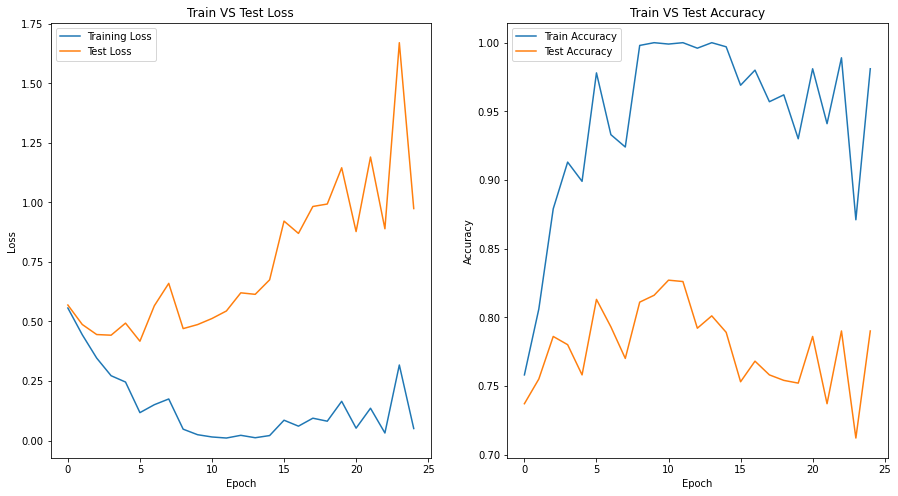

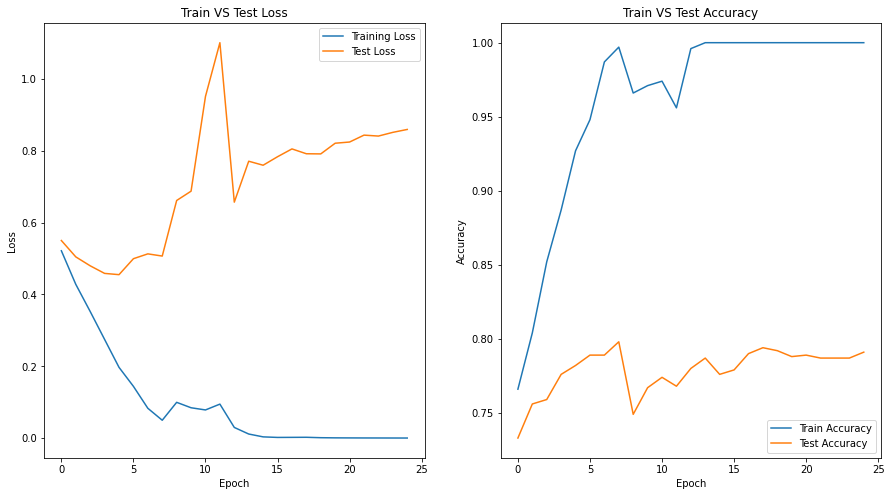

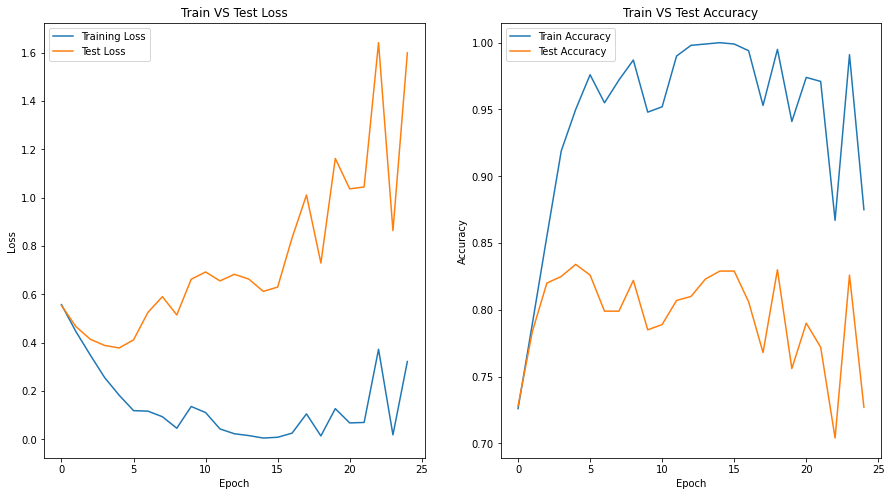

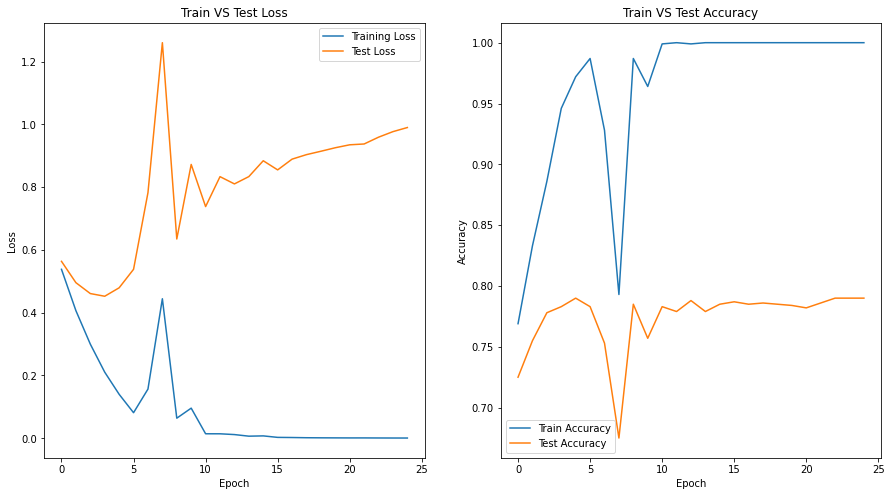

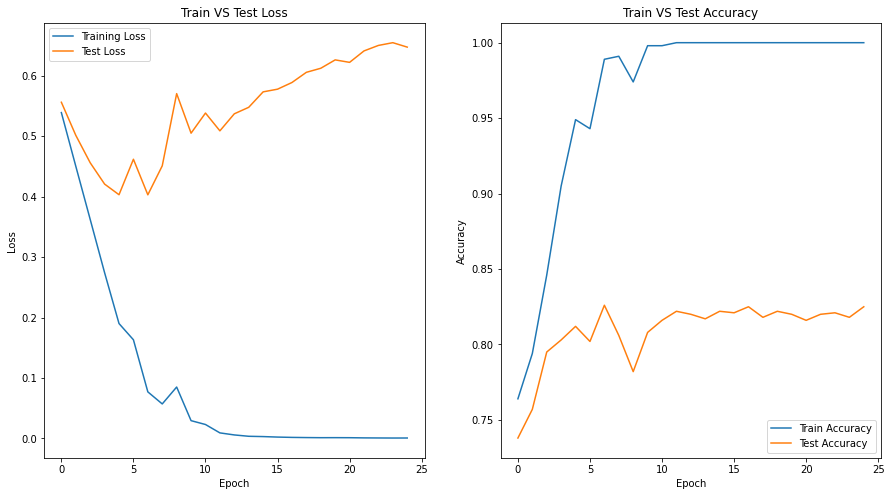

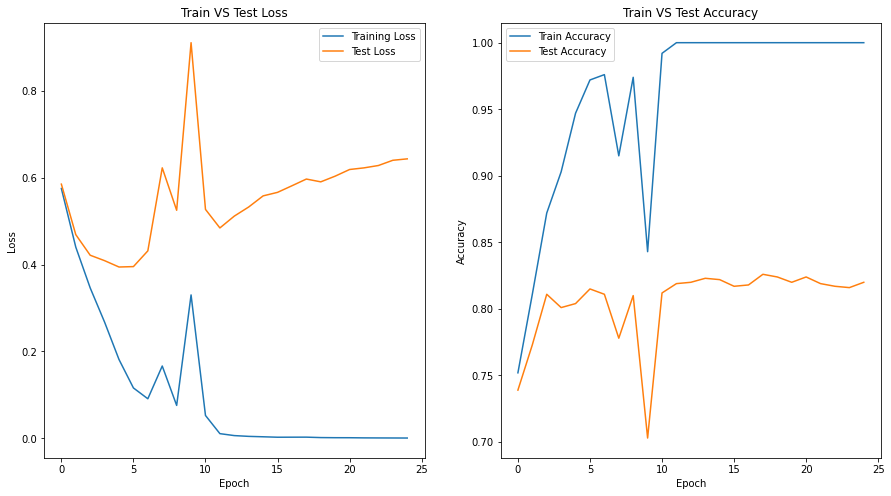

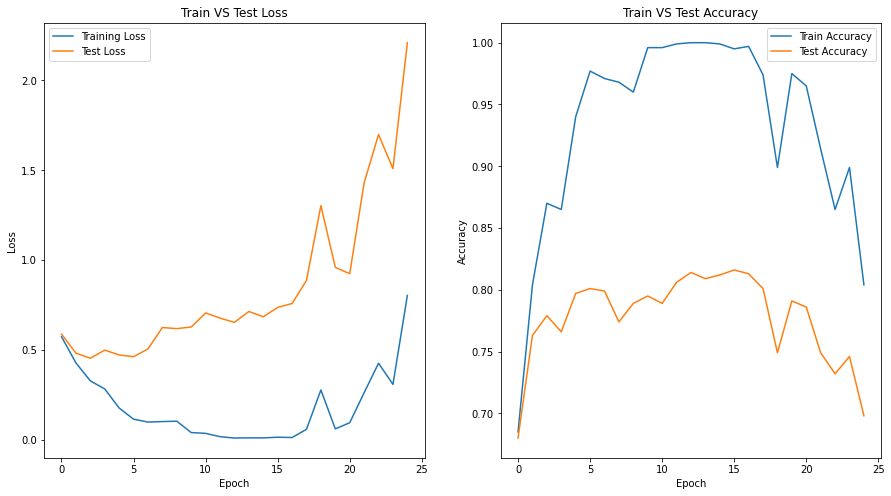

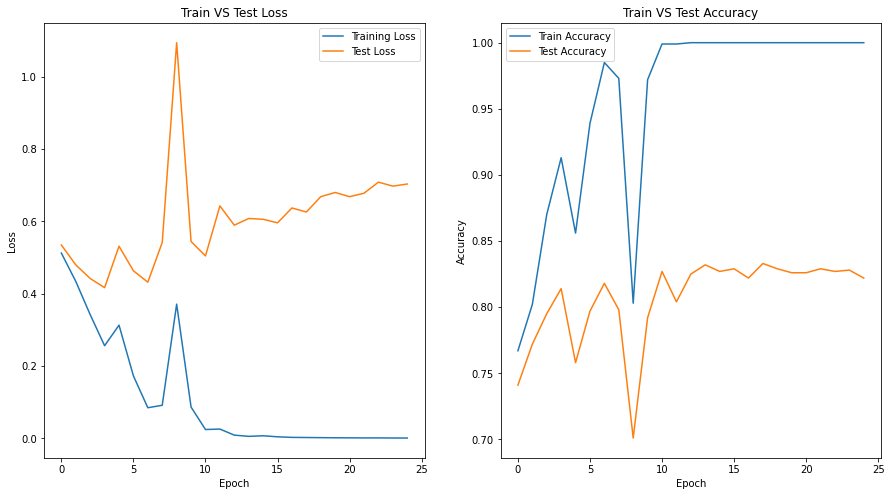

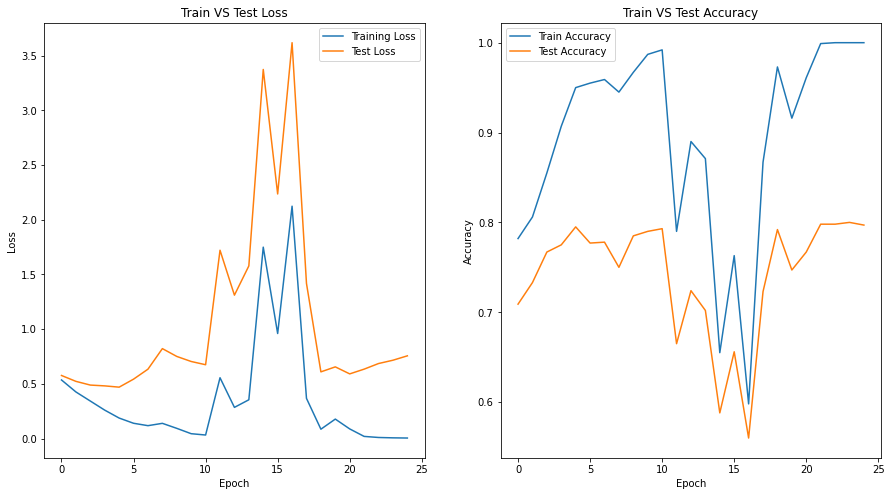

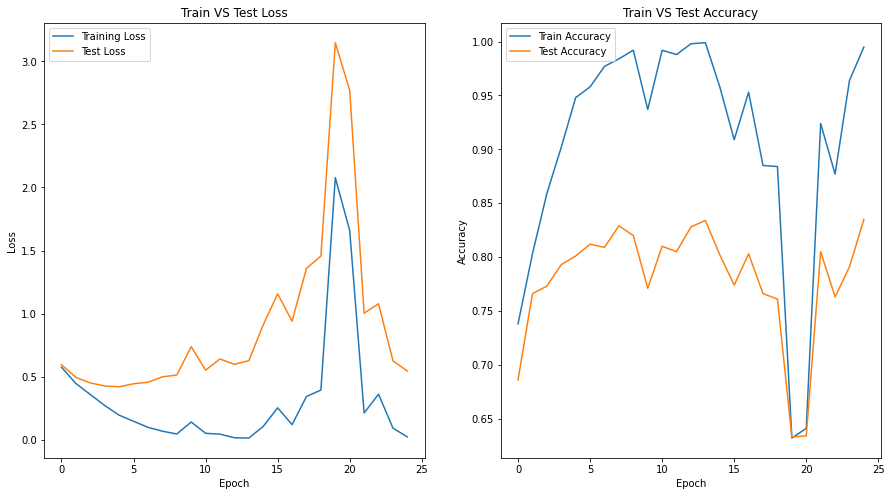

In [36]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net()
    # train the model
    my_model.trainer(train_input, train_target, test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [37]:
# print out the deviation and mean value of the training and testing errors
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.06521080739013034
The standard deviation of test error: 0.04201725376670797
The mean of train error: 0.03449999690055847
The mean of test error: 0.21049999594688415


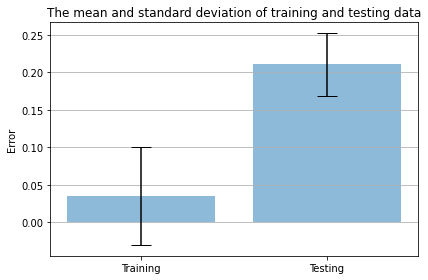

In [38]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors), np.mean(test_errors)]
stds = [np.std(train_errors), np.std(test_errors)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()